In [ ]:
!pip install python-igraph
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install easygui
!pip install cairocffi
!pip install pm4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=085ce212d53e6fdfaa243f138e9f08d3e877c7fd11fb95cdc6b250dfda3ba706
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


In [ ]:
import igraph as ig
import easygui
from matplotlib import pyplot as plt
import numpy as np
import scipy
import statistics
import pandas as pd
import pm4py


In [ ]:
#read data
transactions = pd.read_csv('TRANSACTION1.csv', sep=';')
event_log = pd.read_csv('eventlog.csv', sep=';')

In [ ]:
#join transactions with event log
network_df = pd.merge(event_log, transactions, left_on=['TID'], right_on=['TID'], how='inner')


In [ ]:
network_df=network_df[network_df["Activity"]=="Settling"]
# Grouping by 'FromParticipantId' and 'ToParticipantId' and then summing the 'Value' column
summed_values = network_df.groupby(['FromParticipantId', 'ToParticipantId'])['Value'].sum().reset_index()

# Create a DataFrame containing all possible sender-receiver combinations
senders = network_df['FromParticipantId'].unique()
receivers = network_df['ToParticipantId'].unique()
all_combinations = pd.DataFrame([(sender, receiver) for sender in senders for receiver in receivers], columns=['FromParticipantId', 'ToParticipantId'])

# Left join the summed_values DataFrame with all_combinations DataFrame
summed_values = pd.merge(all_combinations, summed_values, on=['FromParticipantId', 'ToParticipantId'], how='left').fillna(0)
print(network_df)
print(summed_values)

       TID            Starttime              Endtime  Activity  \
4        1  2024-03-03 22:00:02  2024-03-03 22:00:02  Settling   
9        2  2024-03-03 22:00:02  2024-03-03 22:00:02  Settling   
14       3  2024-03-03 22:00:02  2024-03-03 22:00:02  Settling   
19       4  2024-03-03 01:30:01  2024-03-03 01:30:01  Settling   
24       5  2024-03-02 22:00:02  2024-03-02 22:00:02  Settling   
...    ...                  ...                  ...       ...   
8758  2081  2024-03-08 10:17:55  2024-03-08 10:17:55  Settling   
8813  2104  2024-03-08 11:27:28  2024-03-08 11:27:28  Settling   
8824  2108  2024-03-08 11:35:00  2024-03-08 11:35:00  Settling   
8906  2140  2024-03-08 13:26:10  2024-03-08 13:26:10  Settling   
8956  2161  2024-03-08 14:41:38  2024-03-08 14:41:38  Settling   

                     Time         Value  FromParticipantId  FromAccountId  \
4     2024-03-02 00:06:16  3.081666e+08                  5              3   
9     2024-03-02 00:27:32  7.353574e+07              

In [ ]:
print(summed_values["Value"].unique())

[5.31403005e+09 2.12983944e+09 3.91412108e+09 4.15167115e+09
 6.62569756e+09 2.59125963e+09 5.53709513e+09 0.00000000e+00
 4.60202590e+09 2.55479730e+09 3.80137700e+09 4.09548712e+09
 4.85558060e+09 2.73264593e+09 4.16362645e+09 1.85544864e+09
 4.33029825e+09 3.43006466e+09 4.03778105e+09 8.05401866e+09
 4.70606643e+09 4.59814183e+09 6.91689712e+09 4.25290253e+09
 3.52758340e+09 5.07165406e+09 3.76181004e+09 3.64137570e+09
 4.99731309e+09 3.43006466e+09 3.76181004e+09 4.16362645e+09]


In [ ]:
g = ig.Graph(directed=True)

# Create a dictionary to map original vertex IDs to integer IDs
vertex_map = {}
vertices = set(summed_values['FromParticipantId']) | set(summed_values['ToParticipantId'])
for idx, vertex in enumerate(vertices):
    vertex_map[vertex] = idx

# Add vertices
g.add_vertices(len(vertices))

# Add edges with weights
for _, row in summed_values.iterrows():
    source = vertex_map[row['FromParticipantId']]
    target = vertex_map[row['ToParticipantId']]
    weight = row['Value']
    g.add_edge(source, target, weight=weight)
# Prepare labels for nodes
node_labels = [None] * len(vertices)
for vertex, idx in vertex_map.items():
    node_labels[idx] = str(vertex)

print(g.summary())
print(g.closeness())
print(g.vs.attributes())

IGRAPH D-W- 8 64 -- 
+ attr: weight (e)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# Define the graph
g = ig.Graph(directed=True)

# Create a dictionary to map original vertex IDs to integer IDs
vertex_map = {}
vertices = set(summed_values['FromParticipantId']) | set(summed_values['ToParticipantId'])
for idx, vertex in enumerate(vertices):
    vertex_map[vertex] = idx

# Add vertices
g.add_vertices(len(vertices))

# Add edges with weights
for _, row in summed_values.iterrows():
    source = vertex_map[row['FromParticipantId']]
    target = vertex_map[row['ToParticipantId']]
    weight = row['Value']
    g.add_edge(source, target, weight=weight)

    # Add weight as an attribute to the edge
    edge_idx = g.get_eid(source, target)
    g.es[edge_idx]['weight'] = weight

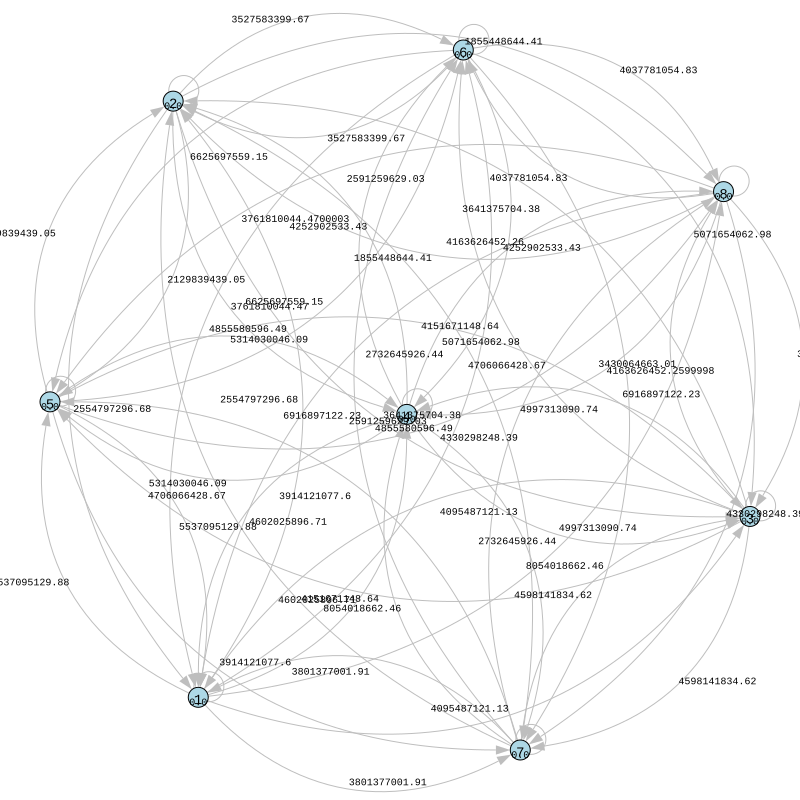

In [ ]:
# Plot the graph with edge labels and node labels
layout = g.layout("fr")
visual_style = {
    "vertex_size": 20,
    "vertex_color": "lightblue",
    "edge_color": "gray",
    "edge_label_size": 10,
    "vertex_label": node_labels,  # Add node labels
    "edge_label": g.es["weight"],  # Use the 'weight' attribute as edge labels
    "bbox": (800, 800),
    "margin": 50
}

ig.plot(g, layout=layout, **visual_style)

In [ ]:
#print basic network statistics
betw=g.betweenness()
print(betw)
degree=g.degree()
print(degree)
closeness=g.closeness()
print(closeness)
pagerank=g.pagerank()
print(pagerank)
avg_path=g.average_path_length()
print(avg_path)
clustering_coeff=g.transitivity_undirected()
print(clustering_coeff)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[16, 16, 16, 16, 16, 16, 16, 16]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.12500000000000003, 0.125, 0.125, 0.12499999999999997, 0.125, 0.125, 0.12499999999999997, 0.125]
1.0
1.0
